# Comparing Voting Methods

In this notebook, we will identify how often voting methods disagree on the winner of an election. 

In [1]:
from  pref_voting.voting_methods import *
from pref_voting.generate_profiles import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from pref_voting.profiles import Profile

In [12]:
voting_methods = [
    split_cycle,
    minimax,
    copeland,
    plurality,
    borda,
    instant_runoff,
    coombs
]

## Generate Profiles

In [14]:
num_cands = 4
num_voters = 1000
num_profiles = 50_000

prob_models = {
    "Impartial Culture": lambda nc, nv, nprofs: generate_profile(nc, nv, num_profiles = nprofs),
    "Mallows": lambda nc, nv, nprofs: generate_profile(nc, nv, probmodel="mallows", phi=0.8, normalise_phi=True, num_profiles = nprofs),
    "Urn": lambda nc, nv, nprofs: generate_profile(nc, nv, probmodel="urn", alpha=5, num_profiles = nprofs),
    "Spatial": lambda nc, nv, nprofs: [sp.to_utility_profile().to_ranking_profile().to_linear_profile() for sp in generate_spatial_profile(nc, nv, 2, num_profiles = nprofs)]
}

profiles = {pm: [] for pm in prob_models.keys()}

for pm in tqdm(prob_models.keys()):
    print("Generating profiles for", pm)
    profiles[pm]=prob_models[pm](num_cands, num_voters, num_profiles)

  0%|          | 0/4 [00:00<?, ?it/s]

Generating profiles for Impartial Culture
Generating profiles for Mallows
Generating profiles for Urn
Generating profiles for Spatial


AttributeError: 'list' object has no attribute 'to_utility_profile'

In [18]:

data_for_diffs = {
    "probability_model": list(),    
    "voting_method": list(),
    "other_vm": list(),
    "perc_diff": list(),
}

for pm in prob_models.keys():
    if pm == "Spatial":
        continue
    print(f"Comparing voting methods for {pm}")
    for vm1 in voting_methods: 
        for vm2 in voting_methods:
            print(f"Comparing {vm1.name} and {vm2.name}")
            num_diff = 0
            for prof in profiles[pm]:
                ws1 = vm1(prof)
                ws2 = vm2(prof)
                if ws1 != ws2: 
                    num_diff += 1
            data_for_diffs["voting_method"].append(vm1.name)
            data_for_diffs["other_vm"].append(vm2.name)
            data_for_diffs["perc_diff"].append(num_diff / len(profiles[pm]))
            data_for_diffs["probability_model"].append(pm)

df_diffs = pd.DataFrame(data_for_diffs)

Comparing Split Cycle and Split Cycle
Comparing Split Cycle and Minimax
Comparing Split Cycle and Copeland
Comparing Split Cycle and Plurality
Comparing Split Cycle and Borda
Comparing Split Cycle and Instant Runoff
Comparing Split Cycle and Coombs
Comparing Minimax and Split Cycle
Comparing Minimax and Minimax
Comparing Minimax and Copeland
Comparing Minimax and Plurality
Comparing Minimax and Borda
Comparing Minimax and Instant Runoff
Comparing Minimax and Coombs
Comparing Copeland and Split Cycle
Comparing Copeland and Minimax
Comparing Copeland and Copeland
Comparing Copeland and Plurality
Comparing Copeland and Borda
Comparing Copeland and Instant Runoff
Comparing Copeland and Coombs
Comparing Plurality and Split Cycle
Comparing Plurality and Minimax
Comparing Plurality and Copeland
Comparing Plurality and Plurality
Comparing Plurality and Borda
Comparing Plurality and Instant Runoff
Comparing Plurality and Coombs
Comparing Borda and Split Cycle
Comparing Borda and Minimax
Compari

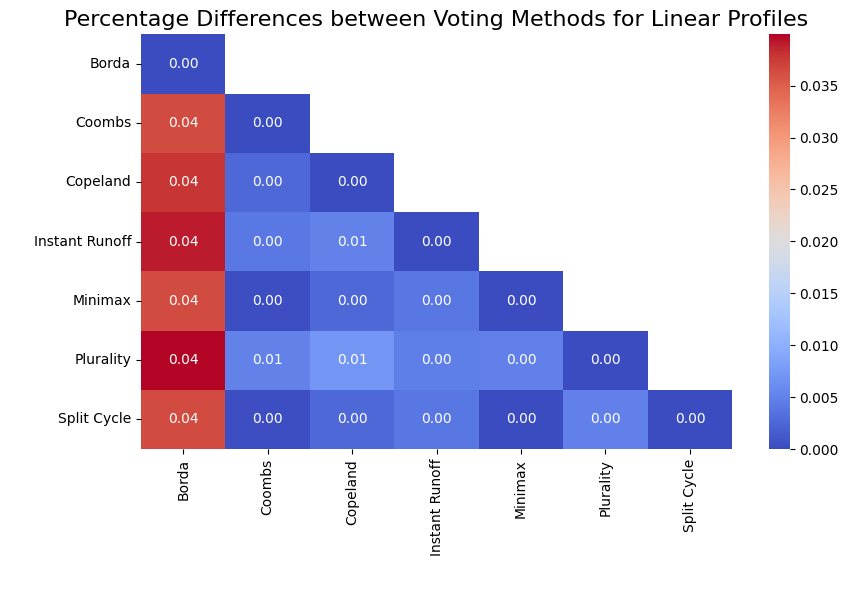

In [23]:
pm = "Urn" #"Impartial Culture"

# Pivot the data for the heatmap
pivot_data = df_diffs[df_diffs['probability_model'] == pm].pivot(index="voting_method", columns="other_vm", values="perc_diff")

# Create a mask for the upper triangle without the diagonal
mask_with_diagonal = np.triu(np.ones_like(pivot_data, dtype=bool), k=1)

fig = plt.figure(figsize=(9, 6))
heatmap = sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f", mask=mask_with_diagonal)
plt.title("Percentage Differences between Voting Methods for Linear Profiles", fontsize=16)
plt.ylabel(" ", fontsize=12)
plt.xlabel(" ", fontsize=12)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.yticks(rotation=0)  # Rotate the y-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()
plt.savefig(f'heatmap_linear_profiles_{num_cands}_{num_voters}_{pm}.pdf')
plt.show()